Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Friday, September 22, 2017.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

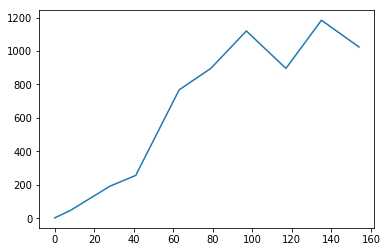

In [2]:
days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

Question 1.1
We can rewrite the logistic model to:

$$\frac{d(log\frac{p}{1-p})}{dt} = r, \text{where } p = \frac{N}{K}$$

So we can $logistic(p)=rt+logistic(p_0), p = \frac{N}{K} \text{and } p_0 = \frac{N_0}{K}$. Finally the solution comes as:

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

The cost function $J$ can be expressed as:
$$J = \frac{1}{2m} (\hat{N_t} - N_t)^2 \sim (\hat{N_t} - N_t)^2$$


The first model using least square error gives K = 1033.515, r = 0.118


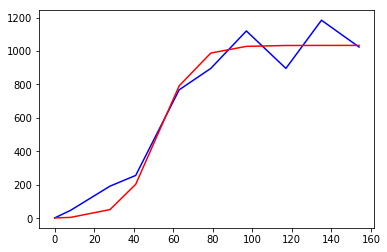

In [7]:
# code for question 1.1
def model(theta, t):
    K = theta[0]
    r = theta[1]
    N_0 = 2
    return N_0*K/(N_0+(K-N_0)*np.exp(-r*t))


def costfunc(theta, t = days, N_t = beetles):
    N_t_hat = model(theta, t)
    return np.sum((N_t_hat - N_t)**2)

days = np.array(days)
beetles = np.array(beetles)
# optimization
from scipy.optimize import minimize
# intialized guess
theta = [500, 0.5]
res = minimize(costfunc, theta, method='Nelder-Mead', tol = 1e-6)
K = res.x[0]
r = res.x[1]
print("The first model using least square error gives K = %.3f, r = %.3f" % (K, r))
model1 = model([K, r], days)

# plot vs the original
plt.plot(days, beetles, c = 'b')
plt.plot(days, model1, c = 'r')

Question 1.2 The assumptions:

$$ Y = log\hat{N_t} \sim N(log(N_t), \sigma^2)$$

So the MLE of $Y$ should be $ \frac{1}{m} \sum log(N_{t_i})$, then the MLE of $\hat N_t$ is $exp[\frac{1}{m} \sum log(N_{t_i})]$.

The first model using MLE gives K = 672.091, r = 0.400


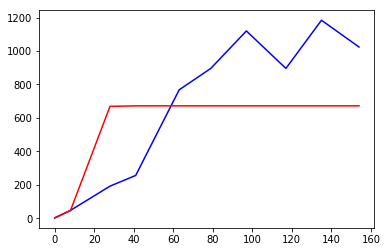

In [9]:
# code for question 1.2

# make small changes to N_t_hat
def costfunc(theta, t = days, N_t = beetles):
    N_t_hat = np.log(model(theta, t))
    return np.sum((N_t_hat - np.log(N_t))**2)

# intialized guess
theta = [500, 0.5]
res = minimize(costfunc, theta, method='Nelder-Mead', tol = 1e-6)
K = res.x[0]
r = res.x[1]
print("The first model using MLE gives K = %.3f, r = %.3f" % (K, r))
model1 = model([K, r], days)

# plot vs the original
plt.plot(days, beetles, c = 'b')
plt.plot(days, model1, c = 'r')

## Question 2

1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.



In [ ]:
baseball = pd.read_table('../data/baseball.dat', sep='\s+')

In [ ]:
# Write your answer here

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there). I will award 5 bonus points to the best solution!

In [ ]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('../data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

In [ ]:
# Write your answer here

## Question 4

The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

From these data files, use `pandas` to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.

In [39]:
!pwd

/Users/ruiwang/source/bios_8366/homework


In [116]:
import os
import glob
import pandas as pd

# three paths
path1 =r'/Users/ruiwang/source/bios_8366/data/ebola/guinea_data'
path2 =r'/Users/ruiwang/source/bios_8366/data/ebola/liberia_data'
path3 =r'/Users/ruiwang/source/bios_8366/data/ebola/sl_data'

# add up
allFiles = []
for path in [path1, path2, path3]:
    allFiles += glob.glob(path + "/*.csv")

ebola = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)

ebola = pd.concat(list_)

# rearrange the columns
col = ebola.columns.tolist()
for x in ['Date', 'Description', 'Totals']:
    col.remove(x)
col = ['Date', 'Description', 'Totals'] + col
ebola = ebola[col].fillna(0)
ebola = ebola[ebola['Description'] == 'Total new cases registered so far']

In [114]:
col

['Date',
 'Description',
 'Totals',
 '34 Military Hospital',
 'Beyla',
 'Bo',
 'Bo EMC',
 'Boffa',
 'Bombali',
 'Bomi County',
 'Bong County',
 'Bonthe',
 'Conakry',
 'Coyah',
 'Dabola',
 'Dalaba',
 'Dinguiraye',
 'Dubreka',
 'Forecariah',
 'Gbarpolu County',
 'Grand Bassa',
 'Grand Cape Mount',
 'Grand Gedeh',
 'Grand Kru',
 'Gueckedou',
 'Hastings-F/Town',
 'Kailahun',
 'Kambia',
 'Kenema',
 'Kenema (IFRC)',
 'Kenema (KGH)',
 'Kerouane',
 'Kindia',
 'Kissidougou',
 'Koinadugu',
 'Kono',
 'Kouroussa',
 'Lofa County',
 'Lola',
 'Macenta',
 'Margibi County',
 'Maryland County',
 'Montserrado County',
 'Moyamba',
 'Mzerekore',
 'National',
 'Nimba County',
 'Nzerekore',
 'Pita',
 'Police training School',
 'Police traning School',
 'Port Loko',
 'Pujehun',
 'River Gee County',
 'RiverCess County',
 'Siguiri',
 'Sinoe County',
 'Telimele',
 'Tonkolili',
 'Unnamed: 18',
 'Variable',
 'Western area',
 'Western area combined',
 'Western area rural',
 'Western area urban',
 'Yomou',
 'date',


In [115]:
ebola

,Date,Description,Totals,34 Military Hospital,Beyla,Bo,Bo EMC,Boffa,Bombali,Bomi County,...,Tonkolili,Unnamed: 18,Variable,Western area,Western area combined,Western area rural,Western area urban,Yomou,date,variable
3,2014-08-04,Total new cases registered so far,9,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
3,2014-08-26,Total new cases registered so far,28,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,7,0,0
3,2014-08-27,Total new cases registered so far,22,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,1,0,0
3,2014-08-30,Total new cases registered so far,24,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,1,0,0
3,2014-08-31,Total new cases registered so far,46,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
3,2014-09-02,Total new cases registered so far,25,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
3,2014-09-04,Total new cases registered so far,30,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
3,2014-09-07,Total new cases registered so far,16,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,1,0,0
3,2014-09-08,Total new cases registered so far,16,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,1,0,0
3,2014-09-09,Total new cases registered so far,16,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
